### In this notebook, I've implemented the [following](https://arxiv.org/pdf/1608.04667.pdf) paper. The aim is to contruct a denoising autoencoder yielding superior results than that from Median filtering. Dental X-ray dataset is used for training and testing.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/medical-image-dataset/Dataset/51.jpg
/kaggle/input/medical-image-dataset/Dataset/103.jpg
/kaggle/input/medical-image-dataset/Dataset/104.jpg
/kaggle/input/medical-image-dataset/Dataset/60.jpg
/kaggle/input/medical-image-dataset/Dataset/110.jpg
/kaggle/input/medical-image-dataset/Dataset/45.jpg
/kaggle/input/medical-image-dataset/Dataset/105.jpg
/kaggle/input/medical-image-dataset/Dataset/41.jpg
/kaggle/input/medical-image-dataset/Dataset/20.jpg
/kaggle/input/medical-image-dataset/Dataset/64.jpg
/kaggle/input/medical-image-dataset/Dataset/24.jpg
/kaggle/input/medical-image-dataset/Dataset/117.jpg
/kaggle/input/medical-image-dataset/Dataset/65.jpg
/kaggle/input/medical-image-dataset/Dataset/63.jpg
/kaggle/input/medical-image-dataset/Dataset/53.jpg
/kaggle/input/medical-image-dataset/Dataset/84.jpg
/kaggle/input/medical-image-dataset/Dataset/73.jpg
/kaggle/input/medical-image-dataset/Dataset/15.jpg
/kaggle/input/medical-image-dataset/Dataset/115.jpg
/kaggle/input/medical-ima

In [2]:
from keras.preprocessing import image

Using TensorFlow backend.


In [3]:
train_images = sorted(os.listdir('/kaggle/input/medical-image-dataset/Dataset'))

### Constructing the dataset in the required format

In [4]:
train_image = []
for im in train_images:
    img = image.load_img('/kaggle/input/medical-image-dataset/Dataset/'+ im, target_size=(64,64), color_mode= 'grayscale')
    img = image.img_to_array(img)
    img = img/255
    train_image.append(img)
train_df = np.array(train_image)

### Defining a plot function

In [5]:
import matplotlib.pyplot as plt

def show_img(dataset):
    f, ax = plt.subplots(1,5)
    f.set_size_inches(40, 20)
    for i in range(5,10):
        ax[i-5].imshow(dataset[i].reshape(64,64), cmap='gray')
    plt.show()

### Defining a function for Noice addition. 0.07 is multiplied as it is the fraction of noice that we want in our picture.

In [6]:
def add_noice(image):
    row,col,ch= image.shape
    mean = 0
    sigma = 1
    gauss = np.random.normal(mean,sigma,(row,col,ch))
    gauss = gauss.reshape(row,col,ch)
    noisy = image + gauss*0.07
    return noisy

In [7]:
noised_df= []

for img in train_df:
    noisy= add_noice(img)
    noised_df.append(noisy)

In [8]:
noised_df= np.array(noised_df)

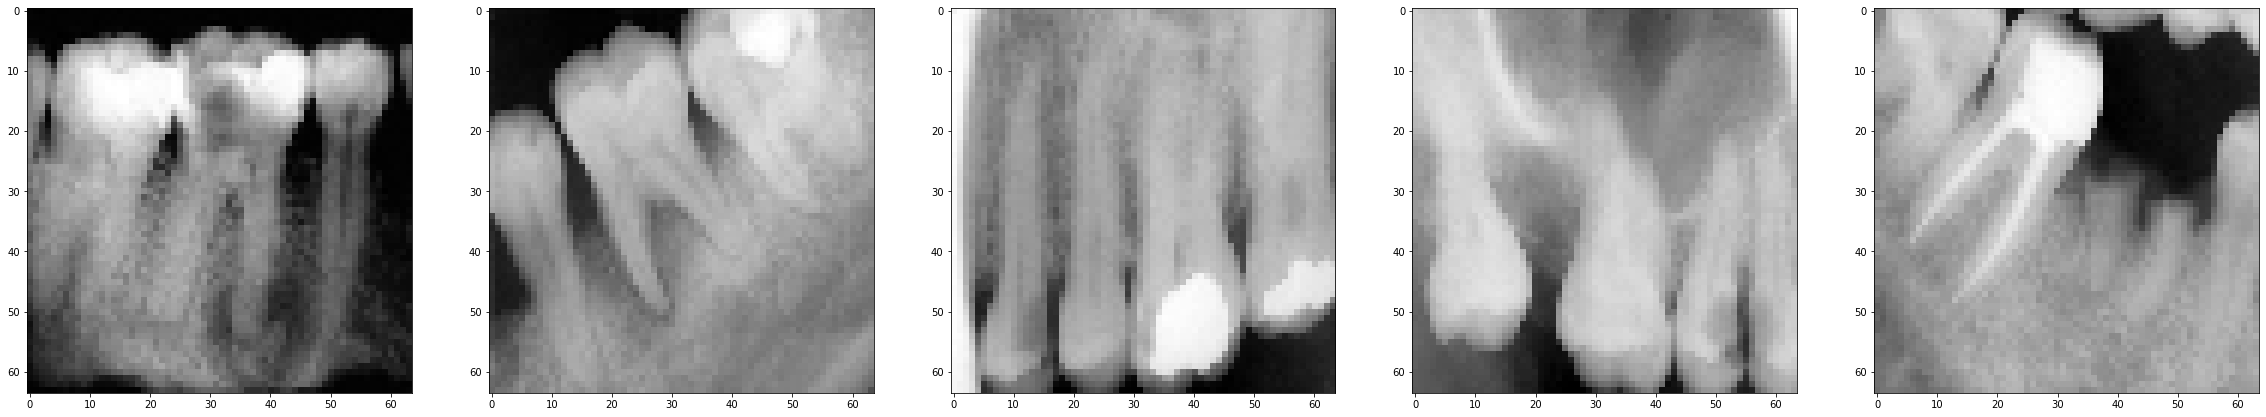

In [9]:
show_img(train_df)

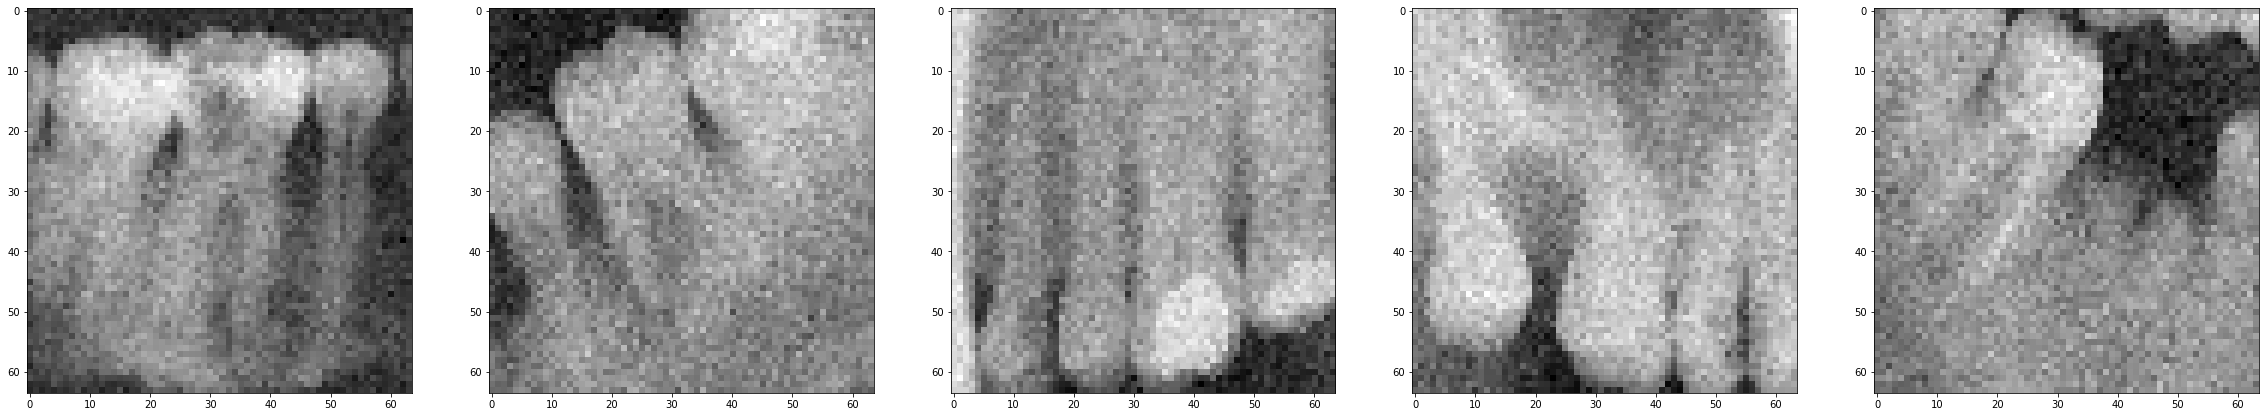

In [10]:
show_img(noised_df)

In [11]:
noised_df.shape

(120, 64, 64, 1)

In [12]:
train_df.shape

(120, 64, 64, 1)

In [13]:
xnoised= noised_df[0:100]
xtest= noised_df[100:]

In [14]:
xnoised.shape

(100, 64, 64, 1)

### Defining the model architecture as per the design suggested in the paper

In [15]:
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, MaxPooling2D,MaxPool2D ,UpSampling2D, Flatten, Input
from keras.optimizers import SGD, Adam, Adadelta, Adagrad
from keras import backend as K

def autoencoder():
    
    input_img = Input(shape=(64,64,1), name='image_input')
    
    #enoder 
    x = Conv2D(64, (3,3), activation='relu', padding='same', name='Conv1')(input_img)
    x = MaxPooling2D((2,2), padding='same', name='pool1')(x)
    x = Conv2D(64, (3,3), activation='relu', padding='same', name='Conv2')(x)
    x = MaxPooling2D((2,2), padding='same', name='pool2')(x)
    
    #decoder
    x = Conv2D(64, (3,3), activation='relu', padding='same', name='Conv3')(x)
    x = UpSampling2D((2,2), name='upsample1')(x)
    x = Conv2D(64, (3,3), activation='relu', padding='same', name='Conv4')(x)
    x = UpSampling2D((2,2), name='upsample2')(x)
    x = Conv2D(1, (3,3), activation='sigmoid', padding='same', name='Conv5')(x)
    
    #model
    autoencoder = Model(inputs=input_img, outputs=x)
    autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
    
    return autoencoder

In [16]:
model= autoencoder()
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image_input (InputLayer)     [(None, 64, 64, 1)]       0         
_________________________________________________________________
Conv1 (Conv2D)               (None, 64, 64, 64)        640       
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 32, 32, 64)        0         
_________________________________________________________________
Conv2 (Conv2D)               (None, 32, 32, 64)        36928     
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 16, 16, 64)        0         
_________________________________________________________________
Conv3 (Conv2D)               (None, 16, 16, 64)        36928     
_________________________________________________________________
upsample1 (UpSampling2D)     (None, 32, 32, 64)        0     

In [17]:
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping

### Paper suggests to set epoch=100, but, due to less computational power available and small dataset, we'll use 40 epochs with a batch size of 10.

In [18]:
with tf.device('/device:GPU:0'):
    early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='auto')
    model.fit(xnoised, xnoised, epochs=40, batch_size=10, validation_data=(xtest, xtest), callbacks=[early_stopping])

Epoch 1/40
10/10 [==============================] - 0s 30ms/step - loss: 0.6708 - val_loss: 0.6524
Epoch 2/40
10/10 [==============================] - 0s 7ms/step - loss: 0.6143 - val_loss: 0.5976
Epoch 3/40
10/10 [==============================] - 0s 7ms/step - loss: 0.5897 - val_loss: 0.5850
Epoch 4/40
10/10 [==============================] - 0s 7ms/step - loss: 0.5786 - val_loss: 0.5777
Epoch 5/40
10/10 [==============================] - 0s 6ms/step - loss: 0.5723 - val_loss: 0.5740
Epoch 6/40
10/10 [==============================] - 0s 6ms/step - loss: 0.5684 - val_loss: 0.5711
Epoch 7/40
10/10 [==============================] - 0s 7ms/step - loss: 0.5660 - val_loss: 0.5696
Epoch 8/40
10/10 [==============================] - 0s 7ms/step - loss: 0.5643 - val_loss: 0.5671
Epoch 9/40
10/10 [==============================] - 0s 6ms/step - loss: 0.5624 - val_loss: 0.5649
Epoch 10/40
10/10 [==============================] - 0s 6ms/step - loss: 0.5615 - val_loss: 0.5641
Epoch 11/40
10/10 

In [19]:
xtrain= train_df[100:]

## Plotting the predictions.

### First row:   Original image
### Second row:  Noice image
### Third row:   Denoised image using Autoencoder
### Fourth row:  Median filter image

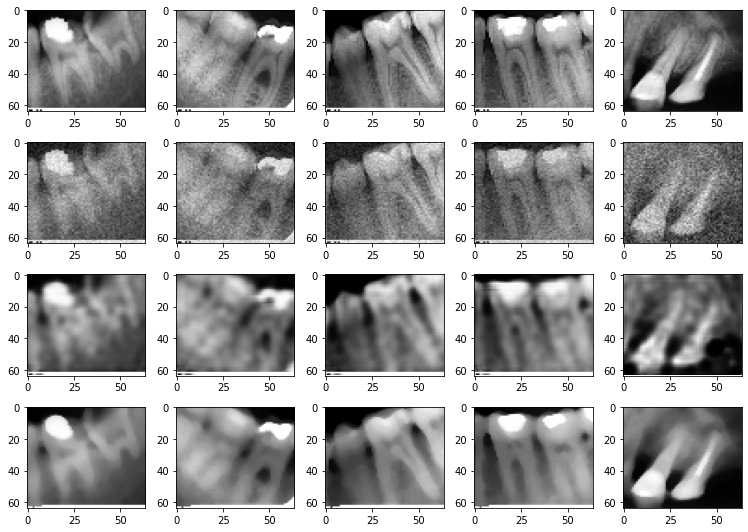

In [20]:
import cv2

pred= model.predict(xtest[:5])
def plot_predictions(y_true, y_pred):    
    f, ax = plt.subplots(4, 5)
    f.set_size_inches(10.5,7.5)
    for i in range(5):
        ax[0][i].imshow(np.reshape(xtrain[i], (64,64)), aspect='auto', cmap='gray')
        ax[1][i].imshow(np.reshape(y_true[i], (64,64)), aspect='auto', cmap='gray')
        ax[2][i].imshow(np.reshape(y_pred[i], (64,64)), aspect='auto', cmap='gray')
        ax[3][i].imshow(cv2.medianBlur(xtrain[i], (5)), aspect='auto', cmap='gray')
       
    plt.tight_layout()
plot_predictions(xtest[:5], pred[:5])

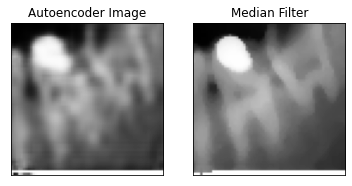

In [21]:
new_image = cv2.medianBlur(xtrain[0], (5))
plt.figure(figsize=(6,3))
plt.subplot(121)
plt.imshow(pred[0].reshape(64,64), cmap='gray')
plt.title('Autoencoder Image')
plt.xticks([])
plt.yticks([])
plt.subplot(122)
plt.imshow(new_image, cmap='gray')
plt.title('Median Filter')
plt.xticks([])
plt.yticks([])
plt.show()

In [22]:
from math import log10, sqrt 
  
def PSNR(original, denoiced): 
    mse = np.mean((original - denoiced) ** 2) 
    if(mse == 0):  # MSE is zero means no noise is present in the signal . 
                  # Therefore PSNR have no importance. 
        return 100
    max_pixel = 255.0
    psnr = 20 * log10(max_pixel / sqrt(mse)) 
    return psnr 
  
value1 = PSNR(xtest[0], new_image)
value2 = PSNR(xtest[0], pred[0])

print(f"PSNR value for Denoised image is {value2} dB while for Median filtered image is {value1} dB")

PSNR value for Denoised image is 69.8926313092242 dB while for Median filtered image is 58.45508992511279 dB
